# Decision Tree

**Author:** Elisa Warner  
**Date:** 04/21/2022  
**Description:** In this code, I attempt to build a Decision Tree from scratch. Note that the code is not optimally written. However, it is designed to be relatively easy to read. I will be using the breast cancer dataset from sklearn datasets and creating binary trees  

Note:  
1. This only works for binary cases  
2. There is one funny thing this code does. The model will try to reach the depth that the user has specified, but in some cases, there is a node which already contains all of the same class. Since it will try to continue on, it overfits a little, and it will still try to split the node (at the lowest threshold seen in the training set). So, you can guess that there is one class, the only class that exists there, which will have another leaf, but the absent class will not have a leaf (imagine a single split rather than a binary split). So, in this case, when I assess the model, if it turns out that for some reason I have a test example which is lower than the threshold, it doesn't have a node to go to. So what I do is I just assign it to the mode class of the node that it is stuck at.

In [909]:
# load libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
np.random.seed(100)

In [910]:
# load data
X,y = load_breast_cancer(return_X_y=True, as_frame=True)

In [911]:
# set hyperparameters
D = 3 # depth
MODEL = {}
N = X.shape[1] # number of features in the bag
K = len(pd.unique(y)) # no of classes

In [912]:
print("Features: " + str(N) + "\nClasses: " + str(K) + '\nShape: ' + str(X.shape))

Features: 30
Classes: 2
Shape: (569, 30)


In [913]:
# Do a 30% split
p = 0.3

In [914]:
# separate into training and testing sets
idx = y.index.values
test_idx = np.random.choice(idx, int(p * X.shape[0]), replace = False)
idx = [x for x in idx if x not in test_idx]

test_X = X.loc[test_idx]
test_y = y.loc[test_idx]
X = X.loc[idx]
y = y.loc[idx]

In [915]:
# QC: confirm that they add up to 569
print("There are %s total rows with training and testing combined" % (X.shape[0] + test_X.shape[0]))

There are 569 total rows with training and testing combined


In [916]:
# should only take in info for that leaf
class Leaf():
    def __init__(self, data, labels, name):
        self.data = data
        self.labels = labels
        self.K = pd.unique(labels) # list of labels
        self.name = name
        
    def __str__(self):
        return "Rows: " + str(self.data.shape[0]) + " \nFeatures: " + str(self.data.shape[1])
    
    def calc_gini_leaf(self):
        tot = 0
        # idx
        idx = self.labels.index.values
        rowSize = self.data.shape[0]
        
        if rowSize == 0:
            return 0
        
        for label in self.K:
            sub_idx = self.labels[self.labels == label].index.values
            regionDataClass = self.data.loc[sub_idx]
            subtot = (regionDataClass.shape[0] / rowSize) * (1 - (regionDataClass.shape[0] / rowSize) )
            tot += subtot
        
        return tot

Notes: If you do RF in the future, RF should do bootstrapping and bagging

In [917]:
# Node should decide the split
class Node():
    def __init__(self, data, labels, level, name):
        self.data = data
        self.labels = labels
        #self.K = pd.unique(labels)
        self.level = level
        self.name = name + "_%s" % level
        
        if level < 0:
            return 0
        
    def __str__(self):
        return "Rows: " + str(self.data.shape[0]) + " \nFeatures: " + str(self.data.shape[1])
    
    # determine the feature and split criteria and this will create leaves and also calculate the GINI index
    def calc_gini_branch(self, splitAt, splitBy): # binary tree
        tot = 0
        
        # split 1
        leafData1 = self.data[self.data[splitAt] >= splitBy]
        names = [z for z in self.features if z != splitAt]
        leafData1 = leafData1[names]
        leafLabels1 = self.labels.loc[leafData1.index.values]
        
        x1 = Leaf(leafData1, leafLabels1, self.name+'+%s' % 1)
        tot += x1.calc_gini_leaf()
        
        # split 0
        leafData0 = self.data[self.data[splitAt] < splitBy][names]
        leafLabels0 = self.labels.loc[leafData0.index.values]
        
        x0 = Leaf(leafData0, leafLabels0, self.name+'+%s' % 0)
        tot += x0.calc_gini_leaf()
        
        return (tot, x0, x1)
    
    # determines the best split criteria
    def split_node(self):
        lowestSplit = (None, np.inf, np.inf) # (feature, gini, splitCriterion)
        self.features = list(self.data)
        
        for layer in range(len(list(self.data))):
            chosenFeature = self.features[layer]
            values = pd.unique(self.data[chosenFeature].values)
            values.sort()
                        
            for v in values:
                gini =  self.calc_gini_branch(chosenFeature, v)
                if gini[0] < lowestSplit[1]:
                    lowestSplit = (chosenFeature, gini[0], v)
        
        if lowestSplit[0] != None:
            print(self.level,lowestSplit)
            MODEL[self.name] = lowestSplit
            
            outClass_idx = self.labels.value_counts().argmax()
            outClass = self.labels.value_counts().index[outClass_idx]
            MODEL['end+%s' % self.name] = outClass
            
        return lowestSplit

In [918]:
class Tree():
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        #self.K = pd.unique(labels)
        self.D = D-1
    
    def __str__(self):
        return "Rows: " + str(self.data.shape[0]) + " \nFeatures: " + str(self.data.shape[1]) + "\nDepth: " + str(self.D)
    
    def createTree(self):
        model = []
        
        # choose D features w/o replacement
        features = list(self.data)
        features = np.random.choice(features, N, replace = False)
        self.data = self.data[features] # limit tree to only these features
        
        node = Node(self.data, self.labels, self.D, "N")
        self.train(node, self.D) # train the tree
        
    def train(self, node, level):
        split = node.split_node()
        leaves = list(node.calc_gini_branch(split[0], split[2]))[1:]

        for leaf in leaves:
            node = Node(leaf.data, leaf.labels, level-1, leaf.name)
            try:
                self.train(node, level-1)
            except:
                continue

# Create the Model

In [919]:
MODEL = {} # in case you need to reset the model

In [920]:
x = Tree(X, y)

Description of output in the cell below: The first number will be the depth level of the node. The second part is a tuple which contains the feature used to split the node, the GINI index of this feature as a classifier, and the cutoff point of that feature for splitting the node.

In [921]:
# create model
x.createTree()

2 ('worst perimeter', 0.22562898567302464, 117.7)
1 ('worst concave points', 0.14622893560453026, 0.1772)
0 ('worst fractal dimension', 0.14059546313799623, 0.05521)
0 ('worst fractal dimension', 0.0, 0.1026)
1 ('worst concave points', 0.0, 0.09975)
0 ('worst fractal dimension', 0.0, 0.05871)
0 ('worst fractal dimension', 0.0, 0.05525)


In [922]:
""" 
The keys in this dictionary show you the decision tree nodes: 
N_A+B_C+D : A and C are levels of depth, B and D are the leaf nodes, 
0 is the left or lower-value leaf node, 1 is the right or higher-value leaf node
"""
list(MODEL)

['N_2',
 'end+N_2',
 'N_2+0_1',
 'end+N_2+0_1',
 'N_2+0_1+0_0',
 'end+N_2+0_1+0_0',
 'N_2+0_1+1_0',
 'end+N_2+0_1+1_0',
 'N_2+1_1',
 'end+N_2+1_1',
 'N_2+1_1+0_0',
 'end+N_2+1_1+0_0',
 'N_2+1_1+1_0',
 'end+N_2+1_1+1_0']

In [923]:
MODEL

{'N_2': ('worst perimeter', 0.22562898567302464, 117.7),
 'end+N_2': 1,
 'N_2+0_1': ('worst concave points', 0.14622893560453026, 0.1772),
 'end+N_2+0_1': 1,
 'N_2+0_1+0_0': ('worst fractal dimension', 0.14059546313799623, 0.05521),
 'end+N_2+0_1+0_0': 1,
 'N_2+0_1+1_0': ('worst fractal dimension', 0.0, 0.1026),
 'end+N_2+0_1+1_0': 0,
 'N_2+1_1': ('worst concave points', 0.0, 0.09975),
 'end+N_2+1_1': 0,
 'N_2+1_1+0_0': ('worst fractal dimension', 0.0, 0.05871),
 'end+N_2+1_1+0_0': 1,
 'N_2+1_1+1_0': ('worst fractal dimension', 0.0, 0.05525),
 'end+N_2+1_1+1_0': 0}

# Predict

In [924]:
# Function to predict one datapoint with a single datapoing (a row of a dataframe) and the model dictionary output from above
def model_predict_single(model, data):
    direction = {}
    name = 'N_%s' % str(D-1)
    counter = D-1
    
    while name in MODEL:
        prev_name = name
        feature = MODEL[name][0]
        criterion = MODEL[name][2]
        
        if data[feature] >= criterion:
            name = name + '+1'
        else:
            name = name + '+0'
        
        counter -= 1
        name = name + '_%s' % counter
    
    outName = 'end+%s' % prev_name
    
    outClass = MODEL[outName]
    
    return outClass

# Calculate AUCs

In [929]:
# load libraries
from sklearn import metrics
import matplotlib.pyplot as plt

In [926]:
# training set
gt_train = []
predict_train = []

for i in range(X.shape[0]):
    test_data = X.iloc[i]
    test_label = y.iloc[i]
    
    predict_train.append(model_predict_single(MODEL, test_data))
    gt_train.append(test_label)

In [927]:
# testing set
gt_test = []
predict_test = []

for i in range(test_X.shape[0]):
    test_data = test_X.iloc[i]
    test_label = test_y.iloc[i]
    
    predict_test.append(model_predict_single(MODEL, test_data))
    gt_test.append(test_label)

Calculate the AUCs and draw ROC curves here

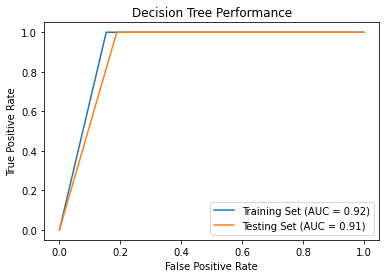

In [928]:
# train set
fig, ax = plt.subplots()
fpr, tpr, threshold = metrics.roc_curve(gt_train, predict_train, pos_label = max(pd.unique(y)))
roc_auc = metrics.auc(fpr, tpr)
display1 = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Training Set')
display1.plot(ax=ax)

# test set
fpr, tpr, threshold = metrics.roc_curve(gt_test, predict_test, pos_label = max(pd.unique(y)))
roc_auc = metrics.auc(fpr, tpr)
display2 = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Testing Set')
display2.plot(ax=ax)

plt.title("Decision Tree Performance")
plt.show()